# ECE 763 Project 02: Vision Transformers

Objectives: 

- To get hands-on experiences on working with images (CIFAR10) and Vision Transformers and Meta-Transformers
- To get familar with PyTorch Lightning pacakge that makes the training easier

### How to submit your solutions

* Add your NCSU ID as the postfix of the notebook filename.
* Submit two versions of your notebook, one is fully executed with all outputs (`Project_02_ViT_twu19_results.ipynb`), and the other with all outputs cleared (`Project_02_ViT_twu19_empty.ipynb`). We will re-run the latter and expect the results will be exactly the same as those in the former. 

## Importing our standard set of libraries.

In [1]:

## Standard libraries
import os
import json
import math
import random
import numpy as np 
import copy
import time

## Imports for plotting
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import cv2
import pandas as pd
import seaborn as sns
sns.set_theme()

## Progress bar
from tqdm.notebook import tqdm

## typing
from typing import (
    Any,
    Callable,
    Dict,
    List,
    Optional,
    Sequence,
    Set,
    Tuple,
    Type,
    Union,
)

try:
    from typing import Literal
except ImportError:
    from typing_extensions import Literal

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## PyTorch Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms


# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: 
    !pip install --quiet pytorch-lightning>=1.6
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Import tensorboard
%load_ext tensorboard


## Identify the system

In [2]:
import platform
from mmengine.utils.dl_utils import collect_env
from pprint import pprint

print("=" * 40, "System Information", "=" * 40)
uname = platform.uname()
print(f"System: {uname.system}")
print(f"Node Name: {uname.node}")
print(f"Release: {uname.release}")
print(f"Version: {uname.version}")
print(f"Machine: {uname.machine}")
print(f"Processor: {uname.processor}")

print("=" * 40, "Environment Information", "=" * 40)
my_env = collect_env()
pprint(my_env)

======================================== System Information ========================================
System: Linux
Node Name: jupyter-yazhuog
Release: 5.15.0-119-generic
Version: #129-Ubuntu SMP Fri Aug 2 19:25:20 UTC 2024
Machine: x86_64
Processor: x86_64
======================================== Environment Information ========================================
OrderedDict([('sys.platform', 'linux'),
             ('Python',
              '3.11.8 | packaged by conda-forge | (main, Feb 16 2024, '
              '20:53:32) [GCC 12.3.0]'),
             ('CUDA available', True),
             ('MUSA available', False),
             ('numpy_random_seed', 2147483648),
             ('GPU 0,1', 'NVIDIA A100-SXM4-40GB'),
             ('CUDA_HOME', None),
             ('GCC', 'gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0'),
             ('PyTorch', '2.2.0+cu121'),
             ('PyTorch compiling details',
              'PyTorch built with:\n'
              '  - GCC 9.3\n'
              '  - C++ Versio

## Set random seeds and devices

In [3]:

# Function for setting the seed
def random_seed(seed: int = 42, rank: int = 0, deterministic: bool = False) -> None:
    torch.manual_seed(seed + rank)
    np.random.seed(seed + rank)
    random.seed(seed + rank)
    # GPU operations have a separate seed we also want to set
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed + rank)
        torch.cuda.manual_seed_all(seed + rank)

        # Additionally, some operations on a GPU are implemented stochastic for efficiency
        # We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
        torch.backends.cudnn.deterministic = deterministic
        torch.backends.cudnn.benchmark = True

seed = 42
random_seed(seed=seed, deterministic=True)

# Fetching the device that will be used throughout this notebook
device = (
    torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
)
print("Using device", device)

Using device cuda:0


## Prepare Datasets (CIFAR10)

In [4]:
# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../checkpoints/ece763_proj_02"
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

### CIFAR10
CIFAR10 is a very popular dataset for computer vision on low-resolution images (32x32 pixels). The task is to classify images into one of 10 classes: **airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck**. 

In [5]:
# Dataset statistics for normalizing the input values to zero mean and one std
DATA_MEANS = [0.491, 0.482, 0.447]
DATA_STD = [0.247, 0.243, 0.261]

test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(DATA_MEANS, DATA_STD)
                                     ])
# For training, we add some augmentation. Networks are too powerful and would overfit.
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomResizedCrop((32,32),scale=(0.8,1.0),ratio=(0.9,1.1)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(DATA_MEANS, DATA_STD)
                                     ])
# Loading the training dataset. We need to split it into a training and validation part
# We need to do a little trick because the validation set should not use the augmentation.
train_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=train_transform, download=True)
val_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=test_transform, download=True)
train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000], generator=torch.Generator().manual_seed(42))
_, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000], generator=torch.Generator().manual_seed(42))

# Loading the test set
test_set = CIFAR10(root=DATASET_PATH, train=False, transform=test_transform, download=True)

# Create data loaders for later. Adjust batch size if you have a smaller GPU
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=3)
val_loader = data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False, num_workers=3)
test_loader = data.DataLoader(test_set, batch_size=128, shuffle=False, drop_last=False, num_workers=3)

# classes
classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck"
)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


When working with data, it is always recommend to look at the data before blaming your model for not performing well if the data was incorrectly processed. Hence, let's plot 1-batch images of the CIFAR10 training dataset:


In [6]:
start_time = time.time()
dataiter = iter(train_loader)
images, labels = next(dataiter)
end_time = time.time()
print(f"Time for loading a batch: {(end_time - start_time):6.5f}s")


Time for loading a batch: 0.39691s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


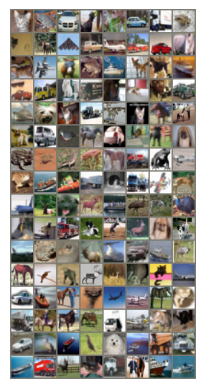

GroundTruth (1st row):  cat   frog  car   dog   frog  car   truck frog 


In [7]:
INV_DATA_MEANS = torch.tensor([-m for m in DATA_MEANS]).view(-1, 1, 1)
INV_DATA_STD = torch.tensor([1.0 / s for s in DATA_STD]).view(-1, 1, 1)


def imshow(img):
    img = img.div_(INV_DATA_STD).sub_(INV_DATA_MEANS)  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.show()
    plt.close()


imshow(torchvision.utils.make_grid(images))
print("GroundTruth (1st row): ", " ".join(f"{classes[labels[j]]:5s}" for j in range(8)))

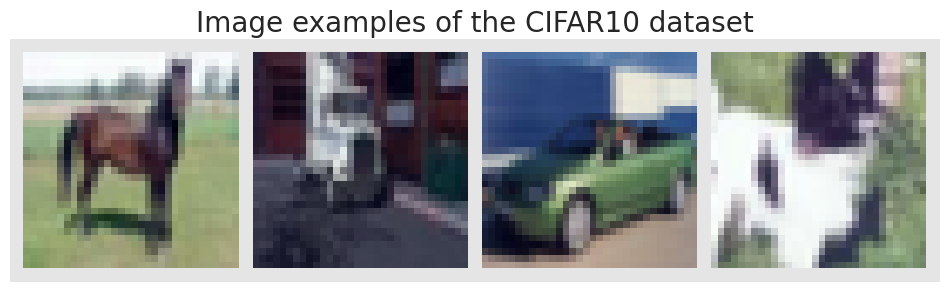

In [8]:
# For later, we keep a set of example images
CIFAR_images = torch.stack([val_set[idx][0] for idx in range(4)], dim=0)
img_grid = torchvision.utils.make_grid(CIFAR_images, nrow=4, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(12,8))
plt.title("Image examples of the CIFAR10 dataset", fontsize=20)
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

## Part 1 [70 points]: Building a Vision Transformer for image classification

Transformers have been originally proposed to process sets since it is a permutation-equivariant architecture, i.e., producing the same output permuted if the input is permuted. To apply Transformers to sequences, one commonly adds a positional encoding to the input feature vectors, and the model learns by itself what to do with it. So, why not do the same thing on images? This is exactly what [Alexey Dosovitskiy et al.](https://openreview.net/pdf?id=YicbFdNTTy) proposed in their paper "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale". Specifically, the Vision Transformer is a model for image classification that views images as sequences of smaller patches. As a preprocessing step, we split an image of, for example, $48\times 48$ pixels into 9 $16\times 16$ patches. Each of those patches is considered to be a "word"/"token" and projected to a feature space. With adding positional encodings and a token for classification on top, we can apply a Transformer as usual to this sequence and start training it for our task. A nice GIF visualization of the architecture is shown below (figure credit - [Phil Wang](https://github.com/lucidrains/vit-pytorch/blob/main/images/vit.gif)):

<center width="100%"><img src="./figures/vit.gif" width="600px"></center>

We will walk step by step through the Vision Transformer, and implement all parts by ourselves. First, let's implement the image preprocessing: an image of size $N\times N$ has to be split into $(N/M)^2$ patches of size $M\times M$. These represent the input words to the Transformer. Implement this logic in the function below:

In [9]:
# 5 points
def img_to_patch(x, patch_size, flatten_channels=True):
    """
    Inputs:
        x - torch.Tensor representing the image of shape [B, C, H, W]
        patch_size - Number of pixels per dimension of the patches (integer)
        flatten_channels - If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    Outputs:
        Tensor of shape [B, H*W/patch_size^2, C, patch_size, patch_size] if flatten_channels=False,
        and [B, H*W/patch_size^2, C*patch_size^2] otherwise.
    """
    # TODO: Implement the splitting of images into patches
    B, C, H, W = x.shape
    # assert H % patch_size == 0 and W % patch_size == 0, "Image dimensions must be divisible by patch size"
    
    # Reshape into patches
    x = x.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)  # [B, C, H/patch_size, W/patch_size, patch_size, patch_size]
    x = x.permute(0, 2, 3, 1, 4, 5).contiguous()  # [B, H/patch_size, W/patch_size, C, patch_size, patch_size]
    x = x.view(B, -1, C, patch_size, patch_size)  # [B, Num_Patches, C, patch_size, patch_size]
    
    if flatten_channels:
        x = x.view(B, x.shape[1], -1)  # [B, Num_Patches, C * patch_size * patch_size]
    
    return x
    raise NotImplementedError

In [10]:
imgs = torch.randn(4, 3, 48, 48)
patch_size = 16
out = img_to_patch(imgs, patch_size, flatten_channels=False)
assert len(out.shape) == 5
assert out.shape[0] == imgs.shape[0]
assert out.shape[1] == imgs.shape[2]*imgs.shape[3]/patch_size**2
assert out.shape[2] == imgs.shape[1]
assert out.shape[3] == patch_size
assert out.shape[4] == patch_size

out = img_to_patch(imgs, patch_size, flatten_channels=True)
assert len(out.shape) == 3
assert out.shape[0] == imgs.shape[0]
assert out.shape[1] == imgs.shape[2]*imgs.shape[3]/patch_size**2
assert out.shape[2] == imgs.shape[1]*patch_size**2

Let's take a look at how that works for our CIFAR examples above. For our images of size $32\times 32$, we choose a patch size of 4. Hence, we obtain sequences of 64 patches of size $4\times 4$. We visualize them below:

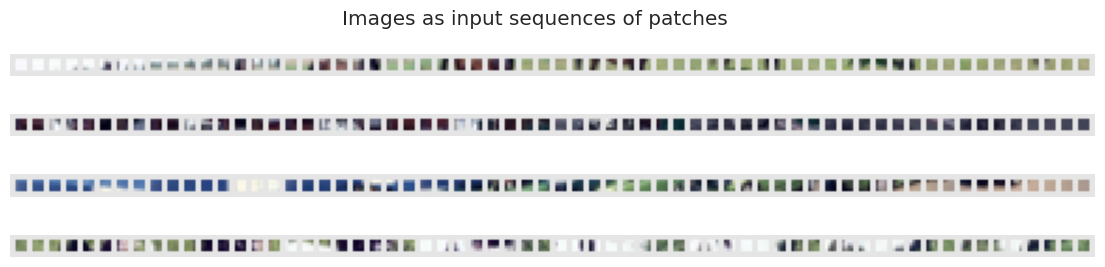

In [11]:
img_patches = img_to_patch(CIFAR_images, patch_size=4, flatten_channels=False)

fig, ax = plt.subplots(CIFAR_images.shape[0], 1, figsize=(14,3))
fig.suptitle("Images as input sequences of patches")
for i in range(CIFAR_images.shape[0]):
    img_grid = torchvision.utils.make_grid(img_patches[i], nrow=64, normalize=True, pad_value=0.9)
    img_grid = img_grid.permute(1, 2, 0)
    ax[i].imshow(img_grid)
    ax[i].axis('off')
plt.show()
plt.close()

Compared to the original images, it is much harder to recognize the objects from those patch lists now. Still, this is the input we provide to the Transformer for classifying the images. The model has to learn itself how it has to combine the patches to recognize the objects. The inductive bias in CNNs that an image is a grid of pixels, is lost in this input format.

After we have looked at the preprocessing, we can now start building the Transformer model. You can make use of the PyTorch module `nn.MultiheadAttention` ([docs](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html?highlight=multihead#torch.nn.MultiheadAttention)) here. Further, we use the Pre-Layer Normalization version of the Transformer blocks proposed by [Ruibin Xiong et al.](http://proceedings.mlr.press/v119/xiong20b/xiong20b.pdf) in 2020. The idea is to apply Layer Normalization not in between residual blocks, but instead as a first layer in the residual blocks. This reorganization of the layers supports better gradient flow and removes the necessity of a warm-up stage. A visualization of the difference between the standard Post-LN and the Pre-LN version is shown below.

<center width="100%"><img src="figures/pre_layer_norm.svg" width="400px"></center>

First, implement a Pre-LN attention block below:

In [12]:
# 20 points
class AttentionBlock(nn.Module):
    
    def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
        """
        Inputs:
            embed_dim - Dimensionality of input and attention feature vectors
            hidden_dim - Dimensionality of hidden layer in feed-forward network 
                         (usually 2-4x larger than embed_dim)
            num_heads - Number of heads to use in the Multi-Head Attention block
            dropout - Amount of dropout to apply in the feed-forward network
        """
        super().__init__()
        # TODO: Implement an pre-LN attention block
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )
        self.attn_drop = nn.Dropout(dropout)
        # raise NotImplementedError
        
    def forward(self, x):
        """
        Inputs:
            x - Input tensor of shape [Num Patches, Batch size, embed_dim]
        """
        # TODO: Implement the forward pass
        # Pre-LN Multi-Head Attention
        x_residual = x  # Save for residual connection
        x = self.norm1(x)
        attn_output, _ = self.attn(x, x, x)
        attn_output = self.attn_drop(attn_output)
        x = x_residual + attn_output  # Residual Connection

        # Pre-LN Feed-Forward Network
        x_residual = x  # Save for residual connection
        x = self.norm2(x)
        x = self.ffn(x)
        x = x_residual + x  # Residual Connection

        return x
        raise NotImplementedError

In [13]:
# Testing the attention block
num_heads = np.random.randint(low=4, high=16)
embed_dim = num_heads * np.random.randint(low=16, high=32)
hidden_dim = np.random.randint(low=128, high=512)
block = AttentionBlock(embed_dim, hidden_dim, num_heads)
block.to(device)
inp = torch.randn(10, 32, embed_dim, device=device)
out = block(inp)
for i in range(len(inp.shape)):
    assert out.shape[i] == inp.shape[i]

# Checking whether batch and patch dimension are correct
inp2 = inp.clone()
inp2[:,0] = 0.0
out2 = block(inp2)
diff = (out - out2).abs()
assert (diff[:,0] > 1e-4).any(), 'Output tensor shows no difference although input has changed'
assert (diff[:,1:] < 1e-4).all(), 'Other tensors besides the changed batch element have altered outputs. Check the dimensions'

Now we have all modules ready to build our own Vision Transformer. Besides the Transformer encoder, we need the following modules:

* A **linear projection** layer that maps the input patches to a feature vector of larger size. It is implemented by a simple linear layer that takes each $M\times M$ patch independently as input.
* A **classification token** that is added to the input sequence. We will use the output feature vector of the classification token (CLS token in short) for determining the classification prediction.
* Learnable **positional encodings** that are added to the tokens before being processed by the Transformer. Those are needed to learn position-dependent information, and convert the set to a sequence. Since we usually work with a fixed resolution, we can learn the positional encodings instead of having the pattern of sine and cosine functions.
* An **MLP head** that takes the output feature vector of the CLS token, and maps it to a classification prediction. This is usually implemented by a small feed-forward network or even a single linear layer.

With those components in mind, let's implement the full Vision Transformer below:

In [14]:
# 20 points
class VisionTransformer(nn.Module):
    
    def __init__(self, embed_dim, hidden_dim, num_channels, num_heads, num_layers, num_classes, patch_size, num_patches, dropout=0.0):
        """
        Inputs:
            embed_dim - Dimensionality of the input feature vectors to the Transformer
            hidden_dim - Dimensionality of the hidden layer in the feed-forward networks
                         within the Transformer
            num_channels - Number of channels of the input (3 for RGB)
            num_heads - Number of heads to use in the Multi-Head Attention block
            num_layers - Number of layers to use in the Transformer
            num_classes - Number of classes to predict
            patch_size - Number of pixels that the patches have per dimension
            num_patches - Maximum number of patches an image can have
            dropout - Amount of dropout to apply in the feed-forward network and 
                      on the input encoding
        """
        super().__init__()
        # TODO: Implement all elements of the full Vision Transform
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim))
        self.projection = nn.Linear(num_channels * patch_size * patch_size, embed_dim)
        
        self.encoder = nn.Sequential(
            *[AttentionBlock(embed_dim, hidden_dim, num_heads, dropout) for _ in range(num_layers)]
        )
        
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )
        # raise NotImplementedError
    
    def forward(self, x):
        # TODO: Implement the forward pass
        B = x.shape[0]
        x = img_to_patch(x, self.patch_size)  # Shape: (B, num_patches, C * patch_size * patch_size)
        x = self.projection(x)  # Shape: (B, num_patches, embed_dim)
        cls_tokens = self.cls_token.expand(B, -1, -1)  # Shape: (B, 1, embed_dim)
        x = torch.cat((cls_tokens, x), dim=1)  # Shape: (B, num_patches + 1, embed_dim)
        x = x + self.pos_embedding
        x = x.permute(1, 0, 2)  # Transformer expects (N, B, E)
        x = self.encoder(x)
        cls_output = x[0]  # Take the CLS token output
        return self.mlp_head(cls_output)
        raise NotImplementedError

In [15]:
# Testing the Vision Transformer module
num_heads = np.random.randint(low=4, high=16)
embed_dim = num_heads * np.random.randint(low=16, high=32)
hidden_dim = np.random.randint(low=128, high=512)
num_channels = 3
num_layers = np.random.randint(low=2, high=4)
num_classes = np.random.randint(low=5, high=20)
patch_size = [2,4,8][np.random.randint(low=0, high=3)]
num_patches = int((32/patch_size)**2)

vit_module = VisionTransformer(embed_dim, hidden_dim, num_channels, num_heads, num_layers, num_classes, patch_size, num_patches)
vit_module.to(device)
imgs = torch.randn(4, 3, 32, 32, device=device)
out = vit_module(imgs)
assert out.shape[0] == imgs.shape[0]
assert out.shape[1] == num_classes

# Checking whether batch and patch dimension are correct
imgs2 = imgs.clone()
imgs2[0] = 0.0
out2 = vit_module(imgs2)
diff = (out2 - out).abs()
assert (diff[0] > 1e-4).any(), 'Output tensor shows no difference although input has changed'
assert (diff[1:] < 1e-4).all(), 'Other tensors besides the changed batch element have altered outputs. Check the dimensions'

Finally, we can put everything into a PyTorch Lightning Module as usual. We use `torch.optim.AdamW` as the optimizer, which is Adam with a corrected weight decay implementation. Since we use the Pre-LN Transformer version, we do not need to use a learning rate warmup stage anymore.

In [16]:
# 15 points
class ViT(pl.LightningModule):
    
    def __init__(self, model_kwargs, lr):
        super().__init__()
        self.save_hyperparameters()
        self.model = VisionTransformer(**model_kwargs)
        self.example_input_array = next(iter(train_loader))[0]
        
    def forward(self, x):
        return self.model(x)
    
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=1e-3)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[75, 90], gamma=0.1)
        return [optimizer], [lr_scheduler]   
    
    def _calculate_loss(self, batch, mode="train"):
        # TODO: Implement step to calculate the loss and accuracy for a batch
        imgs, labels = batch
        preds = self(imgs)  # Forward pass
        loss = F.cross_entropy(preds, labels)  # Cross-entropy loss
        
        acc = (preds.argmax(dim=1) == labels).float().mean()  # Compute accuracy
        
        # Log metrics
        self.log(f"{mode}_loss", loss, prog_bar=True)
        self.log(f"{mode}_acc", acc, prog_bar=True)
        
        return loss
        raise NotImplementedError

    def training_step(self, batch, batch_idx):
        loss = self._calculate_loss(batch, mode="train")
        return loss

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="test")

### Experiments

Commonly, Vision Transformers are applied to large-scale image classification benchmarks such as ImageNet to leverage their full potential. However, here we take a step back and ask: can Vision Transformer also succeed on classical, small benchmarks such as CIFAR10? To find this out, we train a Vision Transformer from scratch on the CIFAR10 dataset. Let's first create a training function for our PyTorch Lightning module which also loads the pre-trained model if you have downloaded it above.

In [17]:
def train_model(max_epochs=100, **kwargs):
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, "ViT"), 
                         devices=1 if str(device)=="cuda:0" else 0,
                         max_epochs=max_epochs,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
                                    LearningRateMonitor("epoch")],
                         check_val_every_n_epoch=10)
    trainer.logger._log_graph = True         # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "ViT.ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = ViT.load_from_checkpoint(pretrained_filename) # Automatically loads the model with the saved hyperparameters
    else:
        pl.seed_everything(42) # To be reproducable
        model = ViT(**kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = ViT.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training

    # Test best model on validation and test set
    val_result = trainer.test(model, val_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)
    result = {"test": test_result[0]["test_acc"], "val": val_result[0]["test_acc"]}

    return model, result

Now, we can already start training our model. As seen in our implementation, we have a couple of hyperparameters that we have to set. When creating this notebook, we have performed a small grid search over hyperparameters and listed the best hyperparameters in the cell below. Nevertheless, it is worth discussing the influence that each hyperparameter has, and what intuition we have for choosing its value.

First, let's consider the patch size. The smaller we make the patches, the longer the input sequences to the Transformer become. While in general, this allows the Transformer to model more complex functions, it requires a longer computation time due to its quadratic memory usage in the attention layer. Furthermore, small patches can make the task more difficult since the Transformer has to learn which patches are close-by, and which are far away. We experimented with patch sizes of 2, 4, and 8 which gives us the input sequence lengths of 256, 64, and 16 respectively. We found 4 to result in the best performance and hence pick it below. 

Next, the embedding and hidden dimensionality have a similar impact on a Transformer as to an MLP. The larger the sizes, the more complex the model becomes, and the longer it takes to train. In Transformers, however, we have one more aspect to consider: the query-key sizes in the Multi-Head Attention layers. Each key has the feature dimensionality of `embed_dim/num_heads`. Considering that we have an input sequence length of 64, a minimum reasonable size for the key vectors is 16 or 32. Lower dimensionalities can restrain the possible attention maps too much. To reduce the computational complexity, we recommend using 4 heads, 128 embedding dimensionality and 256 hidden dimensionality for a start.

Finally, the learning rate for Transformers is usually relatively small, and in papers, a common value to use is 3e-5. However, since we work with a smaller dataset and have a potentially easier task, we found that we are able to increase the learning rate to 3e-4 without any problems.

Feel free to explore the hyperparameters yourself by changing the values below. **For a final run for the report, we recommend to increase the epochs to 100**.

In [18]:
model, results = train_model(model_kwargs={
                                'embed_dim': 128,
                                'hidden_dim': 256,
                                'num_heads': 8,
                                'num_layers': 6,
                                'patch_size': 8,
                                'num_channels': 3,
                                'num_patches': 16,
                                'num_classes': 10,
                                'dropout': 0.2
                              },
                              lr=3e-4,
                              max_epochs=100)
print("ViT results", results)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 42
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type              | Params | Mode  | In sizes         | Out sizes
-----------------------------------------------------------------------------------
0 | model | VisionTransformer | 823 K  | train | [128, 3, 32, 32] | [128, 10]
-----------------------------------------------------------------------------------
823 K     Trainable params
0         Non-trainable params
823 K     Total params
3.294     Total estimated model params size (MB)
78      

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

ViT results {'test': 0.7401000261306763, 'val': 0.7376000285148621}


In [19]:
# Opens tensorboard in notebook. Adjust the path to your CHECKPOINT_PATH!
%tensorboard --logdir "../checkpoints/ece763_proj_02/ViT"

In [20]:
from tensorboard.backend.event_processing import event_accumulator

# Path to the directory containing TensorBoard logs
log_dir = "../checkpoints/ece763_proj_02/ViT/lightning_logs/version_0"

# Load events
ea = event_accumulator.EventAccumulator(log_dir)
ea.Reload()

# Get all scalar tags (e.g., train/loss, val/acc)
tags = ea.Tags()['scalars']

# Dump each tag to CSV
for tag in tags:
    events = ea.Scalars(tag)
    df = pd.DataFrame([(e.step, e.value, e.wall_time) for e in events],
                      columns=['step', 'value', 'wall_time'])
    csv_filename = f"{tag.replace('/', '_')}.csv"
    df.to_csv(csv_filename, index=False)
    print(f"Saved {csv_filename}")

Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Found more than one "run metadata" event with tag step1. Overwriting it with the newest event.
Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Found more than one "run metadata" event with tag step1. Overwriting it with the newest event.


Saved lr-AdamW.csv
Saved train_loss.csv
Saved train_acc.csv
Saved epoch.csv
Saved val_loss.csv
Saved val_acc.csv
Saved test_loss.csv
Saved test_acc.csv


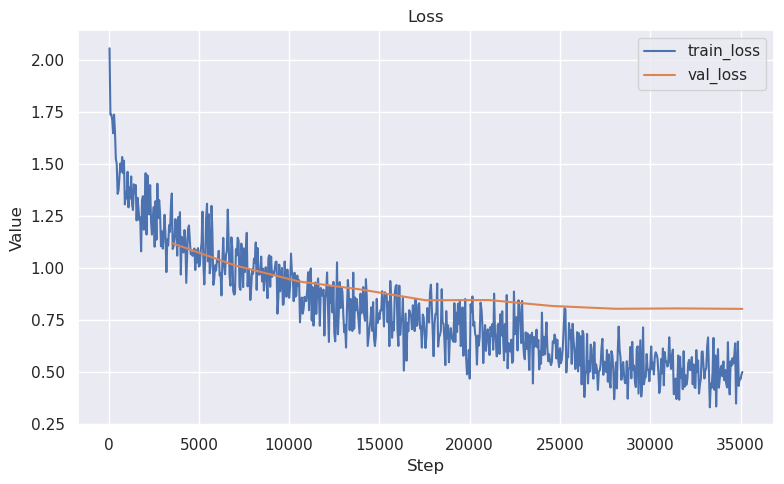

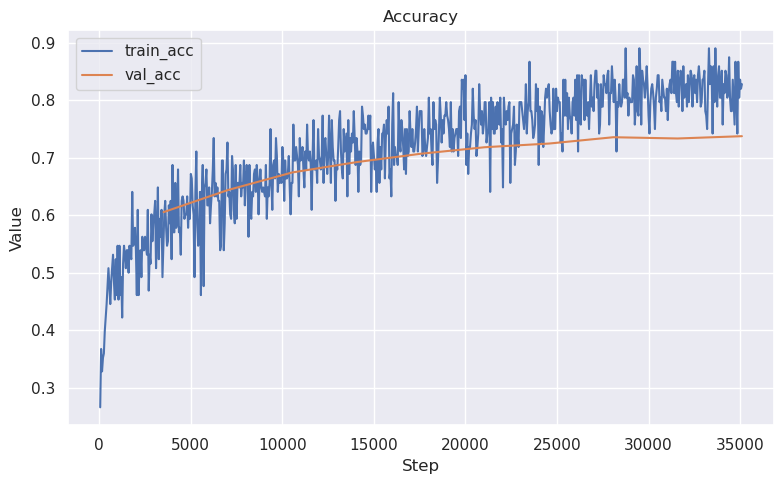

In [21]:
def plot_metric(files, title):
    plt.figure(figsize=(8, 5))
    for file in files:
        if os.path.exists(file):
            df = pd.read_csv(file)
            label = os.path.splitext(file)[0]
            plt.plot(df['step'], df['value'], label=label)
    plt.xlabel("Step")
    plt.ylabel("Value")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{title}.png")
    plt.tight_layout()
    plt.show()

plot_metric(["train_loss.csv", "val_loss.csv"], "Loss")
plot_metric(["train_acc.csv", "val_acc.csv"], "Accuracy")

What accuracy does the ViT achieve? How does this compare to the CNN you have implemented in Project 01? 


### Discussions [10 points]: Add the plots of the validation accuracy and a discussion of the previous questions here

ViT achieved an accuracy of 73.76%, which is similar the CNN in Project 01. But considering epoch for CNN was small to reach such accuracy, CNN is supposed to outperform ViT on CIFAR-10. ViT focuses on global context and longer dependencies, so it would outperform with larger size of data or pretrained models.

## Part 2 [10 points]: Importance of Positional Embeddings

From Homework 3, we have some theoretical understanding of the importance of position embeddings. However, how important are those to the Transformer actually in practice? Do we see a noticable accuracy drop if we don't use the position embeddings? Or is it looking at the images as a big bag of words anyways? Finally, how does this relation change when using different patch sizes? These questions you should try to find an answer in this ablation study. 

Specifically, train a Transformer without positional embeddings, and compare it to your original Transformer. Repeat the experiment for a smaller patch size (4 or even 2) and compare how the accuracies have changed.

In [22]:
# TODO: your experiments here

In [23]:
class VisionTransformer(nn.Module):
    
    def __init__(self, embed_dim, hidden_dim, num_channels, num_heads, num_layers, num_classes, patch_size, num_patches, dropout=0.0):
        """
        Inputs:
            embed_dim - Dimensionality of the input feature vectors to the Transformer
            hidden_dim - Dimensionality of the hidden layer in the feed-forward networks
                         within the Transformer
            num_channels - Number of channels of the input (3 for RGB)
            num_heads - Number of heads to use in the Multi-Head Attention block
            num_layers - Number of layers to use in the Transformer
            num_classes - Number of classes to predict
            patch_size - Number of pixels that the patches have per dimension
            num_patches - Maximum number of patches an image can have
            dropout - Amount of dropout to apply in the feed-forward network and 
                      on the input encoding
        """
        super().__init__()
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.projection = nn.Linear(num_channels * patch_size * patch_size, embed_dim)
        
        self.encoder = nn.Sequential(
            *[AttentionBlock(embed_dim, hidden_dim, num_heads, dropout) for _ in range(num_layers)]
        )
        
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )
    
    def forward(self, x):
        B = x.shape[0]
        x = img_to_patch(x, self.patch_size)  # Shape: (B, num_patches, C * patch_size * patch_size)
        x = self.projection(x)  # Shape: (B, num_patches, embed_dim)
        cls_tokens = self.cls_token.expand(B, -1, -1)  # Shape: (B, 1, embed_dim)
        x = torch.cat((cls_tokens, x), dim=1)  # Shape: (B, num_patches + 1, embed_dim)
        x = x.permute(1, 0, 2)  # Transformer expects (N, B, E)
        x = self.encoder(x)
        cls_output = x[0]  # Take the CLS token output
        return self.mlp_head(cls_output)

In [24]:
model_no_pos, results_no_pos = train_model(model_kwargs={
                                'embed_dim': 128,
                                'hidden_dim': 256,
                                'num_heads': 8,
                                'num_layers': 6,
                                'patch_size': 8,
                                'num_channels': 3,
                                'num_patches': 16,
                                'num_classes': 10,
                                'dropout': 0.2
                              },
                              lr=3e-4,
                              max_epochs=100)
print("ViT without Positional Embedding results", results_no_pos)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type              | Params | Mode  | In sizes         | Out sizes
-----------------------------------------------------------------------------------
0 | model | VisionTransformer | 821 K  | train | [128, 3, 32, 32] | [128, 10]
-----------------------------------------------------------------------------------
821 K     Trainable params
0         Non-trainable params
821 K     Total params
3.285     Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

ViT without Positional Embedding results {'test': 0.6797000169754028, 'val': 0.6814000010490417}


In [25]:
model_nopos_size4, results_nopos_size4 = train_model(model_kwargs={
                                'embed_dim': 128,
                                'hidden_dim': 256,
                                'num_heads': 8,
                                'num_layers': 6,
                                'patch_size': 4,
                                'num_channels': 3,
                                'num_patches': 16,
                                'num_classes': 10,
                                'dropout': 0.2
                              },
                              lr=3e-4,
                              max_epochs=100)
print("ViT without Positional Embedding (patch size 4) results", results_nopos_size4)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type              | Params | Mode  | In sizes         | Out sizes
-----------------------------------------------------------------------------------
0 | model | VisionTransformer | 802 K  | train | [128, 3, 32, 32] | [128, 10]
-----------------------------------------------------------------------------------
802 K     Trainable params
0         Non-trainable params
802 K     Total params
3.211     Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

ViT without Positional Embedding (patch size 4) results {'test': 0.7074999809265137, 'val': 0.7063999772071838}


In [26]:
model_nopos_size2, results_nopos_size2 = train_model(model_kwargs={
                                'embed_dim': 128,
                                'hidden_dim': 256,
                                'num_heads': 8,
                                'num_layers': 6,
                                'patch_size': 2,
                                'num_channels': 3,
                                'num_patches': 16,
                                'num_classes': 10,
                                'dropout': 0.2
                              },
                              lr=3e-4,
                              max_epochs=100)
print("ViT without Positional Embedding (patch size 2) results", results_nopos_size2)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type              | Params | Mode  | In sizes         | Out sizes
-----------------------------------------------------------------------------------
0 | model | VisionTransformer | 798 K  | train | [128, 3, 32, 32] | [128, 10]
-----------------------------------------------------------------------------------
798 K     Trainable params
0         Non-trainable params
798 K     Total params
3.193     Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

ViT without Positional Embedding (patch size 2) results {'test': 0.650600016117096, 'val': 0.6498000025749207}


#### How important are those to the Transformer actually in practice? Do we see a noticable accuracy drop if we don't use the position embeddings?
In practice, positional embeddings are important—but not absolutely essential. Removing positional embeddings from the Vision Transformer (ViT) leads to a noticeable drop in accuracy (~5% in above experiments).

#### Is it looking at the images as a big bag of words anyways?
No, ViT is not just a bag-of-visual-words model—it leverages spatial structure effectively when provided.

#### How does this relation change when using different patch sizes?
Using smaller patch sizes helps mitigate the performance drop from removing positional embeddings, as the model has more fine-grained visual cues to work with. However, extreme small sizes like 2 increase extreme number of tokens which makes model struggling to handle.

### Bonous [5 points]: How to use a depthwise convolution to faciliate the positional encoding based on the reference paper in Problem 1 of HW03


In [27]:
# TODO: your codes here

In [28]:
class VisionTransformer(nn.Module):
    
    def __init__(self, embed_dim, hidden_dim, num_channels, num_heads, num_layers, num_classes, patch_size, num_patches, dropout=0.0):
        super().__init__()
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.num_patches = num_patches
        self.grid_size = int(num_patches**0.5)

        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))

        # Removed: self.pos_embedding
        self.projection = nn.Linear(num_channels * patch_size * patch_size, embed_dim)

        # Depthwise convolution for positional encoding
        self.pos_conv = nn.Sequential(
            nn.Conv2d(embed_dim, embed_dim, kernel_size=3, padding=1, groups=embed_dim),  # Depthwise Convolution
            nn.GELU()
        )

        self.norm = nn.LayerNorm(embed_dim)

        self.encoder = nn.Sequential(
            *[AttentionBlock(embed_dim, hidden_dim, num_heads, dropout) for _ in range(num_layers)]
        )

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )

    def forward(self, x):
        B = x.shape[0]
        x = img_to_patch(x, self.patch_size)  # Shape: (B, num_patches, C * patch_size * patch_size)
        x = self.projection(x)                # Shape: (B, num_patches, embed_dim)

        # Reshape to 2D feature map
        x = x.transpose(1, 2).view(B, self.embed_dim, self.grid_size, self.grid_size)  # [B, E, H', W']

        # Inject spatial info with depthwise convolution
        x = self.pos_conv(x)  # [B, E, H', W']

        # Flatten back to sequence
        x = x.flatten(2).transpose(1, 2)  # [B, num_patches, embed_dim]
        x = self.norm(x)

        # Append class token
        cls_tokens = self.cls_token.expand(B, -1, -1)  # [B, 1, embed_dim]
        x = torch.cat((cls_tokens, x), dim=1)  # [B, num_patches+1, embed_dim]

        # Prepare for transformer (transpose to [N, B, E])
        x = x.permute(1, 0, 2)
        x = self.encoder(x)

        cls_output = x[0]  # Take CLS token output
        return self.mlp_head(cls_output)

In [29]:
model_depthwise, results_depthwise = train_model(model_kwargs={
                                'embed_dim': 128,
                                'hidden_dim': 256,
                                'num_heads': 8,
                                'num_layers': 6,
                                'patch_size': 8,
                                'num_channels': 3,
                                'num_patches': 16,
                                'num_classes': 10,
                                'dropout': 0.2
                              },
                              lr=3e-4,
                              max_epochs=100)
print("ViT Depthwise Convolution results", results_depthwise)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type              | Params | Mode  | In sizes         | Out sizes
-----------------------------------------------------------------------------------
0 | model | VisionTransformer | 822 K  | train | [128, 3, 32, 32] | [128, 10]
-----------------------------------------------------------------------------------
822 K     Trainable params
0         Non-trainable params
822 K     Total params
3.291     Total estimated model params size (MB)
82        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

ViT Depthwise Convolution results {'test': 0.6563000082969666, 'val': 0.6632000207901001}


## Part 3 [20 points]: Meta-Transformer

Play with two out of the four options proposed in [MetaFormer](https://arxiv.org/pdf/2210.13452.pdf), see Fig.2. 

Re-implementation your `AttentionBlock` based on the two options you choose and then test them and compare the performance. 

In [30]:
# TODO: your codes here

### 3.1 Overall IdentityFormer Framework

In [31]:
class PatchEmbed(nn.Module):
    def __init__(self, in_channels, embed_dim):
        super().__init__()
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=7, stride=4, padding=3)
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        x = self.proj(x)
        B, C, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)  # [B, N, C]
        x = self.norm(x)
        return x, H, W

In [32]:
class Downsample(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.conv = nn.Conv2d(in_dim, out_dim, kernel_size=3, stride=2, padding=1)
        self.norm = nn.LayerNorm(out_dim)

    def forward(self, x, H, W):
        B, N, C = x.shape
        x = x.transpose(1, 2).reshape(B, C, H, W)
        x = self.conv(x)
        B, C, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)
        x = self.norm(x)
        return x, H, W

In [33]:
class IdentityFormerBlock(nn.Module):
    def __init__(self, embed_dim, mlp_ratio=2, dropout=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.token_mixer = nn.Identity()
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * mlp_ratio),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim * mlp_ratio, embed_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = x + self.token_mixer(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

In [34]:
class IdentityFormerStage(nn.Module):
    def __init__(self, depth, embed_dim, mlp_ratio, dropout):
        super().__init__()
        self.blocks = nn.Sequential(*[
            IdentityFormerBlock(embed_dim, mlp_ratio, dropout) for _ in range(depth)
        ])

    def forward(self, x):
        return self.blocks(x)

In [35]:
class IdentityFormer(nn.Module):
    def __init__(self, in_channels=3, num_classes=10, 
                 dims=(64, 128, 320, 512), depths=(2, 2, 6, 2), mlp_ratio=2, dropout=0.0):
        super().__init__()
        self.patch_embed = PatchEmbed(in_channels, dims[0])

        self.stage1 = IdentityFormerStage(depths[0], dims[0], mlp_ratio, dropout)
        self.down1 = Downsample(dims[0], dims[1])
        self.stage2 = IdentityFormerStage(depths[1], dims[1], mlp_ratio, dropout)
        self.down2 = Downsample(dims[1], dims[2])
        self.stage3 = IdentityFormerStage(depths[2], dims[2], mlp_ratio, dropout)
        self.down3 = Downsample(dims[2], dims[3])
        self.stage4 = IdentityFormerStage(depths[3], dims[3], mlp_ratio, dropout)

        self.norm = nn.LayerNorm(dims[3])
        self.head = nn.Linear(dims[3], num_classes)

    def forward(self, x):
        x, H, W = self.patch_embed(x)
        x = self.stage1(x)
        x, H, W = self.down1(x, H, W)
        x = self.stage2(x)
        x, H, W = self.down2(x, H, W)
        x = self.stage3(x)
        x, H, W = self.down3(x, H, W)
        x = self.stage4(x)
        x = self.norm(x)
        x = x.mean(dim=1)  # Global average pooling
        return self.head(x)

In [36]:
class ViT(pl.LightningModule):
    
    def __init__(self, model_kwargs, lr):
        super().__init__()
        self.save_hyperparameters()
        self.model = IdentityFormer(**model_kwargs)  # Update Vision Transformer
        self.example_input_array = next(iter(train_loader))[0]
        
    def forward(self, x):
        return self.model(x)
    
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=1e-3)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[75, 90], gamma=0.1)
        return [optimizer], [lr_scheduler]   
    
    def _calculate_loss(self, batch, mode="train"):
        imgs, labels = batch
        preds = self(imgs)  # Forward pass
        loss = F.cross_entropy(preds, labels)  # Cross-entropy loss
        
        acc = (preds.argmax(dim=1) == labels).float().mean()  # Compute accuracy
        
        # Log metrics
        self.log(f"{mode}_loss", loss, prog_bar=True)
        self.log(f"{mode}_acc", acc, prog_bar=True)
        
        return loss
        raise NotImplementedError

    def training_step(self, batch, batch_idx):
        loss = self._calculate_loss(batch, mode="train")
        return loss

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="test")

In [37]:
model_identity, results_identity = train_model(model_kwargs={
                                'in_channels': 3,
                                'num_classes': 10,
                                'dims': (64, 128, 320, 512),     # stage-wise embedding dims
                                'depths': (2, 2, 6, 2),          # number of blocks per stage
                                'mlp_ratio': 2,
                                'dropout': 0.0
                              },
                              lr=3e-4,
                              max_epochs=100)
print("IdentityFormer results", results_identity)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type           | Params | Mode  | In sizes         | Out sizes
--------------------------------------------------------------------------------
0 | model | IdentityFormer | 6.7 M  | train | [128, 3, 32, 32] | [128, 10]
--------------------------------------------------------------------------------
6.7 M     Trainable params
0         Non-trainable params
6.7 M     Total params
26.710    Total estimated model params size (MB)
143       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

IdentityFormer results {'test': 0.8032000064849854, 'val': 0.8051999807357788}


### 3.2 Overall RandFormer Framework

In [38]:
class RandomMixing(nn.Module):
    def __init__(self, max_tokens=196):
        super().__init__()
        self.register_buffer("random_matrix", torch.softmax(torch.rand(max_tokens, max_tokens), dim=-1))

    def forward(self, x):
        B, N, C = x.shape
        matrix = self.random_matrix[:N, :N]
        return torch.einsum("mn, bnc -> bmc", matrix, x)

In [39]:
class RandFormerBlock(nn.Module):
    def __init__(self, embed_dim, token_mixer, hidden_dim, dropout=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.token_mixer = token_mixer  # nn.Identity or RandomMixing
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):  # x: [B, N, C]
        x = x + self.token_mixer(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

In [40]:
class RandFormerStage(nn.Module):
    def __init__(self, depth, embed_dim, hidden_dim, use_random, num_tokens, dropout=0.0):
        super().__init__()
        self.blocks = nn.Sequential(*[
            RandFormerBlock(
                embed_dim,
                token_mixer=RandomMixing(num_tokens) if use_random else nn.Identity(),
                hidden_dim=hidden_dim,
                dropout=dropout
            ) for _ in range(depth)
        ])

    def forward(self, x):
        return self.blocks(x)

In [41]:
class RandFormer(nn.Module):
    def __init__(self, in_channels=3, num_classes=10,
                 dims=(64, 128, 320, 512), depths=(2, 2, 6, 2),
                 mlp_ratio=2, dropout=0.0, input_size=224):
        super().__init__()
        self.patch_embed = PatchEmbed(in_channels, dims[0])
        self.input_size = input_size

        # Estimate max token count (assuming square shape)
        self.token_counts = [
            (input_size // 4) ** 2,  # after PatchEmbed (stride 4)
            (input_size // 8) ** 2,
            (input_size // 16) ** 2,
            (input_size // 32) ** 2,
        ]

        # Build 4 stages with mixer switch (Rand in last 2)
        self.stage1 = RandFormerStage(depths[0], dims[0], dims[0]*mlp_ratio, False, self.token_counts[0], dropout)
        self.down1 = Downsample(dims[0], dims[1])
        self.stage2 = RandFormerStage(depths[1], dims[1], dims[1]*mlp_ratio, False, self.token_counts[1], dropout)
        self.down2 = Downsample(dims[1], dims[2])
        self.stage3 = RandFormerStage(depths[2], dims[2], dims[2]*mlp_ratio, True, self.token_counts[2], dropout)
        self.down3 = Downsample(dims[2], dims[3])
        self.stage4 = RandFormerStage(depths[3], dims[3], dims[3]*mlp_ratio, True, self.token_counts[3], dropout)

        self.norm = nn.LayerNorm(dims[3])
        self.head = nn.Linear(dims[3], num_classes)

    def forward(self, x):
        x, H, W = self.patch_embed(x)
        x = self.stage1(x)
        x, H, W = self.down1(x, H, W)
        x = self.stage2(x)
        x, H, W = self.down2(x, H, W)
        x = self.stage3(x)
        x, H, W = self.down3(x, H, W)
        x = self.stage4(x)
        x = self.norm(x)
        x = x.mean(dim=1)
        return self.head(x)


In [42]:
class ViT(pl.LightningModule):
    
    def __init__(self, model_kwargs, lr):
        super().__init__()
        self.save_hyperparameters()
        self.model = RandFormer(**model_kwargs)  # Update Vision Transformer
        self.example_input_array = next(iter(train_loader))[0]
        
    def forward(self, x):
        return self.model(x)
    
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=1e-3)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[75, 90], gamma=0.1)
        return [optimizer], [lr_scheduler]   
    
    def _calculate_loss(self, batch, mode="train"):
        imgs, labels = batch
        preds = self(imgs)  # Forward pass
        loss = F.cross_entropy(preds, labels)  # Cross-entropy loss
        
        acc = (preds.argmax(dim=1) == labels).float().mean()  # Compute accuracy
        
        # Log metrics
        self.log(f"{mode}_loss", loss, prog_bar=True)
        self.log(f"{mode}_acc", acc, prog_bar=True)
        
        return loss
        raise NotImplementedError

    def training_step(self, batch, batch_idx):
        loss = self._calculate_loss(batch, mode="train")
        return loss

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="test")

In [43]:
model_rand, results_rand = train_model(model_kwargs={
                                'in_channels': 3,
                                'num_classes': 10,
                                'dims': (64, 128, 320, 512),     # stage-wise embedding dims
                                'depths': (2, 2, 6, 2),          # number of blocks per stage
                                'mlp_ratio': 4,
                                'dropout': 0.0,
                                'input_size': 224
                              },
                              lr=3e-4,
                              max_epochs=100)
print("RandFormer results", results_rand)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type       | Params | Mode  | In sizes         | Out sizes
----------------------------------------------------------------------------
0 | model | RandFormer | 11.4 M | train | [128, 3, 32, 32] | [128, 10]
----------------------------------------------------------------------------
11.4 M    Trainable params
0         Non-trainable params
11.4 M    Total params
45.611    Total estimated model params size (MB)
143       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

RandFormer results {'test': 0.7936999797821045, 'val': 0.8064000010490417}


### 3.3 Overall ConvFormer Framework

In [44]:
class SepConv(nn.Module):
    def __init__(self, embed_dim, expansion_ratio=2, kernel_size=7, padding=3, bias=False):
        super().__init__()
        mid_dim = int(embed_dim * expansion_ratio)
        self.pw1 = nn.Linear(embed_dim, mid_dim, bias=bias)  # pointwise conv
        self.dw = nn.Conv2d(mid_dim, mid_dim, kernel_size=kernel_size, padding=padding,
                            groups=mid_dim, bias=bias)  # depthwise conv
        self.pw2 = nn.Linear(mid_dim, embed_dim, bias=bias)  # pointwise conv

    def forward(self, x):  # x: [B, N, C]
        B, N, C = x.shape
        H = W = int(N**0.5)
        x = self.pw1(x)
        x = x.view(B, -1, H, W)  # [B, C, H, W]
        x = self.dw(x)
        x = x.flatten(2).transpose(1, 2)  # [B, N, C]
        x = self.pw2(x)
        return x

In [45]:
class ConvFormerBlock(nn.Module):
    def __init__(self, embed_dim, hidden_dim, dropout=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.token_mixer = SepConv(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):  # x: [B, N, C]
        x = x + self.token_mixer(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

In [46]:
class ConvFormerStage(nn.Module):
    def __init__(self, depth, embed_dim, hidden_dim, dropout=0.0):
        super().__init__()
        self.blocks = nn.Sequential(*[
            ConvFormerBlock(embed_dim, hidden_dim, dropout) for _ in range(depth)
        ])

    def forward(self, x):
        return self.blocks(x)

In [47]:
class ConvFormer(nn.Module):
    def __init__(self, in_channels=3, num_classes=10,
                 dims=(64, 128, 320, 512), depths=(2, 2, 6, 2),
                 mlp_ratio=2, dropout=0.0):
        super().__init__()
        self.patch_embed = PatchEmbed(in_channels, dims[0])

        self.stage1 = ConvFormerStage(depths[0], dims[0], dims[0]*mlp_ratio, dropout)
        self.down1 = Downsample(dims[0], dims[1])
        self.stage2 = ConvFormerStage(depths[1], dims[1], dims[1]*mlp_ratio, dropout)
        self.down2 = Downsample(dims[1], dims[2])
        self.stage3 = ConvFormerStage(depths[2], dims[2], dims[2]*mlp_ratio, dropout)
        self.down3 = Downsample(dims[2], dims[3])
        self.stage4 = ConvFormerStage(depths[3], dims[3], dims[3]*mlp_ratio, dropout)

        self.norm = nn.LayerNorm(dims[3])
        self.head = nn.Linear(dims[3], num_classes)

    def forward(self, x):
        x, H, W = self.patch_embed(x)
        x = self.stage1(x)
        x, H, W = self.down1(x, H, W)
        x = self.stage2(x)
        x, H, W = self.down2(x, H, W)
        x = self.stage3(x)
        x, H, W = self.down3(x, H, W)
        x = self.stage4(x)
        x = self.norm(x)
        x = x.mean(dim=1)  # Global average pooling
        return self.head(x)

In [48]:
class ViT(pl.LightningModule):
    
    def __init__(self, model_kwargs, lr):
        super().__init__()
        self.save_hyperparameters()
        self.model = ConvFormer(**model_kwargs)  # Update Vision Transformer
        self.example_input_array = next(iter(train_loader))[0]
        
    def forward(self, x):
        return self.model(x)
    
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=1e-3)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[75, 90], gamma=0.1)
        return [optimizer], [lr_scheduler]   
    
    def _calculate_loss(self, batch, mode="train"):
        imgs, labels = batch
        preds = self(imgs)  # Forward pass
        loss = F.cross_entropy(preds, labels)  # Cross-entropy loss
        
        acc = (preds.argmax(dim=1) == labels).float().mean()  # Compute accuracy
        
        # Log metrics
        self.log(f"{mode}_loss", loss, prog_bar=True)
        self.log(f"{mode}_acc", acc, prog_bar=True)
        
        return loss
        raise NotImplementedError

    def training_step(self, batch, batch_idx):
        loss = self._calculate_loss(batch, mode="train")
        return loss

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="test")

In [49]:
model_conv, results_conv = train_model(model_kwargs={
                                'in_channels': 3,
                                'num_classes': 10,
                                'dims': (64, 128, 320, 512),     # stage-wise embedding dims
                                'depths': (2, 2, 6, 2),          # number of blocks per stage
                                'mlp_ratio': 4,
                                'dropout': 0.0
                              },
                              lr=3e-4,
                              max_epochs=100)
print("ConvFormer results", results_conv)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type       | Params | Mode  | In sizes         | Out sizes
----------------------------------------------------------------------------
0 | model | ConvFormer | 16.4 M | train | [128, 3, 32, 32] | [128, 10]
----------------------------------------------------------------------------
16.4 M    Trainable params
0         Non-trainable params
16.4 M    Total params
65.790    Total estimated model params size (MB)
179       Modules in train mode
0         Modules in eval mode
/tmp/ipykernel_60386/3880359574.py:12: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  H = W = int(N**0.5)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

ConvFormer results {'test': 0.807699978351593, 'val': 0.8245999813079834}


### 3.4 Overall CAFormer Framework

In [50]:
class SelfAttention(nn.Module):
    def __init__(self, dim, num_heads):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, batch_first=True)

    def forward(self, x):  # x: [B, N, C]
        return self.attn(x, x, x)[0]

In [51]:
class CAFormerBlock(nn.Module):
    def __init__(self, embed_dim, hidden_dim, mixer_type="conv", num_heads=8, dropout=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

        if mixer_type == "conv":
            self.token_mixer = SepConv(embed_dim)  # from ConvFormer
        elif mixer_type == "attn":
            self.token_mixer = SelfAttention(embed_dim, num_heads)
        else:
            raise ValueError("Unknown mixer_type")

        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        x = x + self.token_mixer(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

In [52]:
class CAFormerStage(nn.Module):
    def __init__(self, depth, embed_dim, hidden_dim, mixer_type="conv", num_heads=8, dropout=0.0):
        super().__init__()
        self.blocks = nn.Sequential(*[
            CAFormerBlock(embed_dim, hidden_dim, mixer_type, num_heads, dropout)
            for _ in range(depth)
        ])

    def forward(self, x):
        return self.blocks(x)

In [53]:
class CAFormer(nn.Module):
    def __init__(self, in_channels=3, num_classes=10,
                 dims=(64, 128, 320, 512), depths=(2, 2, 6, 2),
                 mlp_ratio=2, num_heads=8, dropout=0.0):
        super().__init__()
        self.patch_embed = PatchEmbed(in_channels, dims[0])

        self.stage1 = CAFormerStage(depths[0], dims[0], dims[0]*mlp_ratio, mixer_type="conv", dropout=dropout)
        self.down1 = Downsample(dims[0], dims[1])
        self.stage2 = CAFormerStage(depths[1], dims[1], dims[1]*mlp_ratio, mixer_type="conv", dropout=dropout)
        self.down2 = Downsample(dims[1], dims[2])
        self.stage3 = CAFormerStage(depths[2], dims[2], dims[2]*mlp_ratio, mixer_type="attn", num_heads=num_heads, dropout=dropout)
        self.down3 = Downsample(dims[2], dims[3])
        self.stage4 = CAFormerStage(depths[3], dims[3], dims[3]*mlp_ratio, mixer_type="attn", num_heads=num_heads, dropout=dropout)

        self.norm = nn.LayerNorm(dims[3])
        self.head = nn.Linear(dims[3], num_classes)

    def forward(self, x):
        x, H, W = self.patch_embed(x)
        x = self.stage1(x)
        x, H, W = self.down1(x, H, W)
        x = self.stage2(x)
        x, H, W = self.down2(x, H, W)
        x = self.stage3(x)
        x, H, W = self.down3(x, H, W)
        x = self.stage4(x)
        x = self.norm(x)
        x = x.mean(dim=1)
        return self.head(x)

In [54]:
class ViT(pl.LightningModule):
    
    def __init__(self, model_kwargs, lr):
        super().__init__()
        self.save_hyperparameters()
        self.model = CAFormer(**model_kwargs)  # Update Vision Transformer
        # self.example_input_array = next(iter(train_loader))[0]
        
    def forward(self, x):
        return self.model(x)
    
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=1e-3)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[75, 90], gamma=0.1)
        return [optimizer], [lr_scheduler]   
    
    def _calculate_loss(self, batch, mode="train"):
        imgs, labels = batch
        preds = self(imgs)  # Forward pass
        loss = F.cross_entropy(preds, labels)  # Cross-entropy loss
        
        acc = (preds.argmax(dim=1) == labels).float().mean()  # Compute accuracy
        
        # Log metrics
        self.log(f"{mode}_loss", loss, prog_bar=True)
        self.log(f"{mode}_acc", acc, prog_bar=True)
        
        return loss
        raise NotImplementedError

    def training_step(self, batch, batch_idx):
        loss = self._calculate_loss(batch, mode="train")
        return loss

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="test")

In [55]:
model_CA, results_CA = train_model(model_kwargs={
                                'in_channels': 3,
                                'num_classes': 10,
                                'dims': (64, 128, 320, 512),     # stage-wise embedding dims
                                'depths': (2, 2, 6, 2),          # number of blocks per stage
                                'mlp_ratio': 7,
                                'num_heads': 8,
                                'dropout': 0.0
                              },
                              lr=3e-4,
                              max_epochs=100)
print("CAFormer results", results_CA)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type     | Params | Mode 
-------------------------------------------
0 | model | CAFormer | 23.3 M | train
-------------------------------------------
23.3 M    Trainable params
0         Non-trainable params
23.3 M    Total params
93.034    Total estimated model params size (MB)
171       Modules in train mode
0         Modules in eval mode
/opt/conda/lib/python3.11/site-packages/pytorch_lightning/loggers/tensorboard.py:195: Could not log computational graph to TensorBoard: The `model.example_input_array` attribute is not set or `input_array` was not given.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

CAFormer results {'test': 0.8183000087738037, 'val': 0.8274000287055969}


#### The final results of four frameworks are:

In [56]:
print("IdentityFormer results", results_identity)
print("RandFormer results", results_rand)
print("ConvFormer results", results_conv)
print("CAFormer results", results_CA)

IdentityFormer results {'test': 0.8032000064849854, 'val': 0.8051999807357788}
RandFormer results {'test': 0.7936999797821045, 'val': 0.8064000010490417}
ConvFormer results {'test': 0.807699978351593, 'val': 0.8245999813079834}
CAFormer results {'test': 0.8183000087738037, 'val': 0.8274000287055969}


#### The ranking among the four frames are: 

IdentityFormer < RandFormer < ConvFormer < CAFormer


## References

Dosovitskiy, Alexey, et al. "An image is worth 16x16 words: Transformers for image recognition at scale." International Conference on Representation Learning (2021). [link](https://arxiv.org/pdf/2010.11929.pdf)

Chen, Xiangning, et al. "When Vision Transformers Outperform ResNets without Pretraining or Strong Data Augmentations." arXiv preprint arXiv:2106.01548 (2021). [link](https://arxiv.org/abs/2106.01548)

Tolstikhin, Ilya, et al. "MLP-mixer: An all-MLP Architecture for Vision." arXiv preprint arXiv:2105.01601 (2021). [link](https://arxiv.org/abs/2105.01601)

Xiong, Ruibin, et al. "On layer normalization in the transformer architecture." International Conference on Machine Learning. PMLR, 2020. [link](http://proceedings.mlr.press/v119/xiong20b/xiong20b.pdf)

Yu, Weihao, Chenyang Si, Pan Zhou, Mi Luo, Yichen Zhou, Jiashi Feng, Shuicheng Yan, and Xinchao Wang. "Metaformer baselines for vision." IEEE Transactions on Pattern Analysis and Machine Intelligence (2023). [link](https://arxiv.org/pdf/2210.13452.pdf)

https://github.com/phlippe/asci_cbl_practicals